## Load the necessary libariary and data

In [2551]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import scipy.stats as stats
import seaborn as sns
import pickle
import time
import random
import matplotlib.pyplot as plt
import umap


import pandas as pd

from IPython.display import Image
from umap import UMAP

from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import r2_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore', category=FutureWarning)

train = pd.read_csv('./data/train.csv')
train_labels = train[['regression target', 'classification target']]
train = train.drop(['regression target', 'classification target'], axis=1)
test = pd.read_csv('./data/test.csv')

#### Tuning Variables:

In [2552]:
# fixed variables
random_seed = 4211

# Feature Engineering
n_index = 0
c_index = 0
f_index = 0
fe_index = 0
n_pca = 15

# Model selection and validation
running_index = -1 # -1 for tuning and testing, please RESET to -1 after running
exist_index = -1 # -1 for test only the target model, 0 for test all models after the testing

## Feedforward Neural Network
repeats_index = 3 

## Logistic Regression
lr_para = {
    'learning_rate':'constant', 
    'eta0':0.01, 
    'max_iter':1000, 
    'tol':1e-3
    }

In [2553]:
### Different models
if running_index == -1:
    n_index = 0
    c_index = 2
    f_index = 0
    fe_index = 1
    n_pca = 15

if running_index in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    n_index = 1
    c_index = 2
    fe_index = 1

## Part 2:  Data Preprocessing Techniques

### [Q7] Handling Missing Values: 

In [2554]:
imputer = SimpleImputer(strategy='mean')

numeric_data = train.select_dtypes(include=[np.number])
numeric_data_imputed = imputer.fit_transform(numeric_data)

train[numeric_data.columns] = numeric_data_imputed

### [Q8] Normalization and Standardization:

In [2555]:
scaler_SS = StandardScaler()
scaler_MM = MinMaxScaler()
scaler_RS = RobustScaler()

train_SS = train.copy()
train_MM = train.copy()
train_RS = train.copy()

train_SS[numeric_data.columns] = scaler_SS.fit_transform(numeric_data_imputed)
train_MM[numeric_data.columns] = scaler_MM.fit_transform(numeric_data_imputed)
train_RS[numeric_data.columns] = scaler_RS.fit_transform(numeric_data_imputed)

first_numeric_column_index = 0
for i in range(len(train.columns)):
    column_name = train.columns[i]
    if train[column_name].dtype != 'object':
        first_numeric_column_index = i
        break

print('Original: ')
print(train.iloc[:, first_numeric_column_index].head(10))
print('Standard Scaler: ')
print(train_SS.iloc[:, first_numeric_column_index].head(10))
print('MinMax Scaler: ')
print(train_MM.iloc[:, first_numeric_column_index].head(10))
print('Robust Scaler: ')
print(train_RS.iloc[:, first_numeric_column_index].head(10))

Original: 
0    65.00
1    65.00
2    59.50
3    66.55
4    71.00
5    70.00
6    57.50
7    65.50
8    70.00
9    80.00
Name: C6, dtype: float64
Standard Scaler: 
0   -0.200135
1   -0.200135
2   -1.031074
3    0.034039
4    0.706344
5    0.555264
6   -1.333234
7   -0.124595
8    0.555264
9    2.066063
Name: C6, dtype: float64
MinMax Scaler: 
0    0.368421
1    0.368421
2    0.252632
3    0.401053
4    0.494737
5    0.473684
6    0.210526
7    0.378947
8    0.473684
9    0.684211
Name: C6, dtype: float64
Robust Scaler: 
0   -0.206667
1   -0.206667
2   -0.940000
3    0.000000
4    0.593333
5    0.460000
6   -1.206667
7   -0.140000
8    0.460000
9    1.793333
Name: C6, dtype: float64


### [Q9] Encoding Categorical Variables:

In [2556]:
# using OneHotEncoder and OrdinalEncoder to encode the categorical data

encoder_OHE = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder_OE = OrdinalEncoder()

categorical_data = train[train.columns.difference(numeric_data.columns)]

categorical_data_encoded_OHE = pd.DataFrame()

for column in categorical_data.columns:
    encoded_column = encoder_OHE.fit_transform(categorical_data[[column]])
    column_names = [f"{column}_{category}" for category in encoder_OHE.categories_[0]]
    encoded_column = pd.DataFrame(encoded_column, columns=column_names)
    categorical_data_encoded_OHE = pd.concat([categorical_data_encoded_OHE, encoded_column], axis=1)
    
categorical_data_encoded_OE = pd.DataFrame(encoder_OE.fit_transform(categorical_data), columns=categorical_data.columns)

print('Original: ')
print(categorical_data.iloc[:10, 0])

print('OneHotEncoder: ')
print(categorical_data_encoded_OHE.iloc[:10, 0:7])

print('OrdinalEncoder: ')
print(categorical_data_encoded_OE.iloc[:10, 0])

Original: 
0    divorced
1      single
2      single
3     married
4      single
5      single
6      single
7      single
8      single
9      single
Name: C0, dtype: object
OneHotEncoder: 
   C0_divorced  C0_facto union  C0_legally separated  C0_married  C0_single  \
0          1.0             0.0                   0.0         0.0        0.0   
1          0.0             0.0                   0.0         0.0        1.0   
2          0.0             0.0                   0.0         0.0        1.0   
3          0.0             0.0                   0.0         1.0        0.0   
4          0.0             0.0                   0.0         0.0        1.0   
5          0.0             0.0                   0.0         0.0        1.0   
6          0.0             0.0                   0.0         0.0        1.0   
7          0.0             0.0                   0.0         0.0        1.0   
8          0.0             0.0                   0.0         0.0        1.0   
9          0.0     

### [Q10] Feature Selection:

In [2557]:
train_final = pd.DataFrame()

if n_index == 0:
    train_n = train.select_dtypes(include=[np.number])
elif n_index == 1:
    train_n = train_SS.select_dtypes(include=[np.number])
elif n_index == 2:
    train_n = train_MM.select_dtypes(include=[np.number])
else:
    train_n = train_RS.select_dtypes(include=[np.number])

if c_index == 0:
    train_c = categorical_data
elif c_index == 1:
    train_c = categorical_data_encoded_OHE
else:
    train_c = categorical_data_encoded_OE

train_final = pd.concat([train_n, train_c], axis=1)

train_c_sp = categorical_data_encoded_OE

# print(train_final.head(10))

# using VarianceThreshold or SelectKBest to select the features
selector_VT = VarianceThreshold(threshold=0.1)
selector_SKB = SelectKBest(k=15)

if f_index == 0:
    train_f = train_final
elif f_index == 1:
    train_f = selector_VT.fit_transform(train_final)
elif f_index == 2:
    train_f = imputer.fit_transform(train_final)
    train_f = selector_SKB.fit_transform(train_f, train_labels['regression target']) 
else:
    train_f = imputer.fit_transform(train_final)
    train_f = selector_SKB.fit_transform(train_f, train_labels['classification target'])



### [Q11] Feature Engineering: 

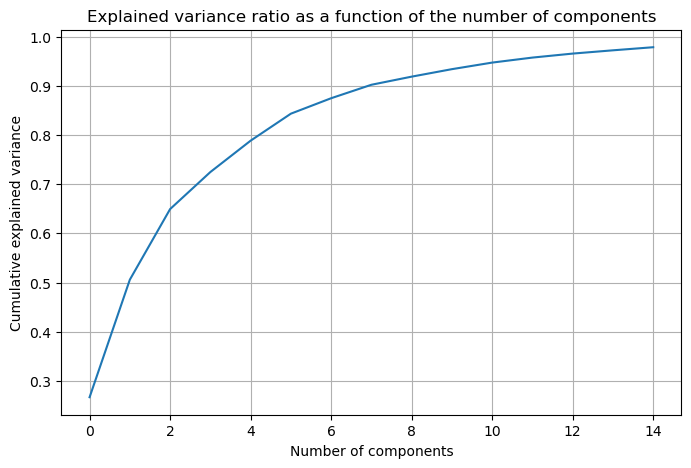

In [2558]:
# using PCA, UMAP to reduce the dimensionality of the data
pca = PCA(n_components=n_pca)


if fe_index == 0:
    train_fe = train_f
elif fe_index == 1:
    train_fe = imputer.fit_transform(train_f)
    train_fe = pca.fit_transform(train_fe)
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Explained variance ratio as a function of the number of components')
    plt.grid(True)
    if not os.path.exists('./pic'):
        os.makedirs('./pic')
    plt.savefig('./pic/PCA.png')
    plt.show()
else:
    train_fe = umap.fit_transform(train_f)

## Part 3: Regression

In [2559]:
np.random.seed(4211)
X_train, X_test, y_train, y_test = train_test_split(train_fe, train_labels['regression target'], test_size=0.2, random_state=4211)

### Linear Regerssion

##### Training Function for All Linear Model:

In [2560]:
def train_model(X_train, y_train, X_test, y_test, n, regressor=LinearRegression()):
    index_using = [0,1,9,5,3,4]
    if n <= 5 and n >= 0:
        index = index_using[n]
        x = X_train[:,index].reshape(-1, 1)
        x_v = X_test[:,index].reshape(-1, 1)
    elif n == 6:
        index = index_using
        x = X_train[:,index]
        x_v = X_test[:,index]
    else:
        print("Invalid index")
        return None
    
    y = y_train.values 

    
    lm = regressor.fit(x, y)

    print("Coefficient:", lm.coef_)
    print("Intercept:", lm.intercept_)
    print("R^2 score:", lm.score(x, y))

    # print the validation r2 score
    y_pred = lm.predict(x_v)
    y_v = y_test.values
    print("Validation R^2 score:", r2_score(y_v, y_pred))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
        
    with open(f'./result/regression/model{n+1}.txt', 'w') as f:
        f.write("Coefficient: " + str(lm.coef_) + '\n')
        f.write("Intercept: " + str(lm.intercept_) + '\n')
        f.write("R^2 score: " + str(lm.score(x, y)) + '\n')
        f.write("Validation R^2 score: " + str(r2_score(y_v, y_pred)) + '\n')

    with open(f'./result/regression/model{n+1}.pkl', 'wb') as f:
        pickle.dump(lm, f)

    return lm

def mse_pred(i):
    if i == 0:
        with open('./result/regression/model1.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,0].reshape(-1, 1))
    elif i == 1:
        with open('./result/regression/model2.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,1].reshape(-1, 1))
    elif i == 2:
        with open('./result/regression/model3.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,9].reshape(-1, 1))
    elif i == 3:
        with open('./result/regression/model4.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,5].reshape(-1, 1))
    elif i == 4:
        with open('./result/regression/model5.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,3].reshape(-1, 1))
    elif i == 5:
        with open('./result/regression/model6.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,4].reshape(-1, 1))
    elif i == 6:
        with open('./result/regression/model7.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,[0,1,3,4,5,9]])
    if i <= 6 and i >= 0:
        mse = np.mean((y_pred - y_test.values) ** 2)
        print("MSE for model", i+1, ":", mse)
        with open('./result/regression/mse.txt', 'a') as f:
            f.write("MSE for model " + str(i+1) + ": " + str(mse) + "\n")
    


#### Step 1:

##### First model:

In [2561]:
# use the PCA10 of SS+OE data to regress the regression target linearly
if running_index == 0:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1
else:
    # print the result from the saved model
    with open('./result/regression/model1.txt', 'r') as f:
        print(f.read())

Coefficient: [0.00052226]
Intercept: 0.6338738086954843
R^2 score: 0.001869531629063781
Validation R^2 score: 0.00494776279640774



##### Second model:

In [2562]:
# use the PCA2 of SS+OE data to regress the regression target linearly
if running_index == 1:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1
else:
    # print the result from the saved model
    with open('./result/regression/model2.txt', 'r') as f:
        print(f.read())
        

Coefficient: [0.00040033]
Intercept: 0.6339274687727884
R^2 score: 0.0007037263251145065
Validation R^2 score: 0.005404304670441729



##### Third model:

In [2563]:
# use the PCA10 of SS+OE data to regress the regression target linearly
if running_index == 2:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1
else:
    # print the result from the saved model
    with open('./result/regression/model3.txt', 'r') as f:
        print(f.read())

Coefficient: [0.03836043]
Intercept: 0.6341330491162769
R^2 score: 0.28052203342764537
Validation R^2 score: 0.32358168954322764



##### Forth model:

In [2564]:
# use the PCA6 of SS+OE data to regress the regression target linearly
if running_index == 3:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1
else:
    # print the result from the saved model
    with open('./result/regression/model4.txt', 'r') as f:
        print(f.read())

Coefficient: [0.00285896]
Intercept: 0.633911316577684
R^2 score: 0.0031871125899599617
Validation R^2 score: 0.006365959135546717



##### Fifth model:

In [2565]:
# use the PCA4 of SS+OE data to regress the regression target linearly
if running_index == 4:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1
else:
    # print the result from the saved model
    with open('./result/regression/model5.txt', 'r') as f:
        print(f.read())

Coefficient: [-0.00291074]
Intercept: 0.6339912370415771
R^2 score: 0.00938766462088203
Validation R^2 score: 0.005735289304080515



##### Sixth model:

In [2566]:
# use the PCA5 of SS+OE data to regress the regression target linearly
if running_index == 5:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1
else:
    # print the result from the saved model
    with open('./result/regression/model6.txt', 'r') as f:
        print(f.read())

Coefficient: [-0.00324559]
Intercept: 0.6339735814916271
R^2 score: 0.004886260271825815
Validation R^2 score: 0.007215904460342593



#### Step 2:

In [2567]:
# use all used data to regress the regression target linearly
if running_index == 6:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1
else:
    # print the result from the saved model
    with open('./result/regression/model7.txt', 'r') as f:
        print(f.read())

Coefficient: [ 0.00046876  0.00054505  0.03858791  0.003116   -0.00312154 -0.00358015]
Intercept: 0.6340903973461227
R^2 score: 0.3037528306576748
Validation R^2 score: 0.3425592691707223



#### MSE for all model:

In [2568]:
# compute all MSE for all models and save it 
for i in range(7):
    mse_pred(i)

MSE for model 1 : 0.004907158786051521
MSE for model 2 : 0.004925981556899324
MSE for model 3 : 0.010572709582298516
MSE for model 4 : 0.00502498309615678
MSE for model 5 : 0.005153013267585405
MSE for model 6 : 0.00481661772908613
MSE for model 7 : 0.03381797500849826


#### Repeating Q12, Q13 using a categorical feature:

In [2569]:
# use a categorical feature to regress the regression target linearly
if running_index == 7:    
    using_index = 1

    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(imputer.fit_transform(train_c_sp), train_labels['regression target'], test_size=0.2, random_state=4211)

    regressor=LinearRegression()
    
    x = X_train_c[:,using_index]
    x = x.reshape(-1, 1)
    y = y_train_c.values

    lm_8 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    X_test_c= X_test_c[:,using_index].reshape(-1, 1)
    y_pred_c = lm_8.predict(X_test_c)
    y_test_c = y_test_c.values

    print("Validation R^2 score:", r2_score(y_test_c, y_pred_c))

    mse = np.mean((y_pred_c - y_test_c) ** 2)
    print("MSE for model", running_index+1, ":", mse)

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model8.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
        f.write("Validation R^2 score: " + str(r2_score(y_test_c, y_pred_c)) + "\n")
        f.write("MSE: " + str(mse) + "\n")
    with open('./result/regression/model8.pkl', 'wb') as f:
        pickle.dump(lm_8, f)

    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1
else:
    # print the result from the saved model
    with open('./result/regression/model8.txt', 'r') as f:
        print(f.read())


Coefficient: [0.00063889]
Intercept: 0.6305448043768958
R^2 score: 0.002696133285668423
Validation R^2 score: 0.00626279509076233
MSE: 0.004833949055816101



### Feedforward Neural Networks

In [2570]:
hidden_units = [1, 8, 32, 128]

mean_r2_all = []

np.random.seed(random_seed)
random.seed(random_seed)

if running_index == 8:

    results = {}

    for h in hidden_units:

        training_times = []
        r2_scores = []
        
        for _ in range(repeats_index): 

            random_state = random.randint(5000, 6000)

            start_time = time.time()
            model = MLPRegressor(hidden_layer_sizes=(h, h, h), early_stopping=True, max_iter=800, random_state=random_state)
            model.fit(X_train[:, [0, 1, 3, 4, 5, 9]], y_train)
            training_time = time.time() - start_time
            training_times.append(training_time)
            
            y_pred = model.predict(X_test[:, [0, 1, 3, 4, 5, 9]])
            score = r2_score(y_test, y_pred)
            r2_scores.append(score)
        

        mean_time = np.mean(training_times)
        std_time = np.std(training_times)
        mean_r2 = np.mean(r2_scores)
        std_r2 = np.std(r2_scores)

        mean_r2_all.append(mean_r2)
        
        results[h] = {
            'training_times': training_times,
            'r2_scores': r2_scores,
            'mean_r2': mean_r2,
            'std_r2': std_r2,
        }
        
        print(f"Hidden units: {h}")
        print(f"Training times: {training_times}")
        print(f"R2 scores: {r2_scores}")
        print(f"mean time: {mean_time:.4f}, std time: {std_time:.4f}")
        print(f"Mean R2: {mean_r2:.4f}, Std R2: {std_r2:.4f}\n")
        
        if not os.path.exists('./result/regression'):
            os.makedirs('./result/regression')
        
        with open(f'./result/regression/model9_H{h}.txt', 'w') as f:
            f.write(f"Training times: {training_times}\n")
            f.write(f"R2 scores: {r2_scores}\n")
            f.write(f"mean time: {mean_time:.4f}, std time: {std_time:.4f}\n")
            f.write(f"Mean R2: {mean_r2:.4f}, Std R2: {std_r2:.4f}\n")
        
        with open(f'./result/regression/model9_H{h}.pkl', 'wb') as f:
            pickle.dump(model, f)

else:
    for h in hidden_units:
        with open(f'./result/regression/model9_H{h}.txt', 'r') as f:
            print(f.read())




Training times: [1.2932984828948975, 0.38060998916625977, 0.26445579528808594]
R2 scores: [0.07566221131869955, 0.059761835320688794, -0.0009274553901152949]
mean time: 0.6461, std time: 0.4601
Mean R2: 0.0448, Std R2: 0.0330

Training times: [0.5673935413360596, 0.8282465934753418, 1.3797292709350586]
R2 scores: [0.29031946711144174, 0.26985210373855484, 0.24426796457022792]
mean time: 0.9251, std time: 0.3386
Mean R2: 0.2681, Std R2: 0.0188

Training times: [1.5102357864379883, 1.2948970794677734, 1.8779735565185547]
R2 scores: [0.35848811699991423, 0.2543176589773687, 0.20716199934317725]
mean time: 1.5610, std time: 0.2407
Mean R2: 0.2733, Std R2: 0.0632

Training times: [1.9369778633117676, 2.0767807960510254, 1.6194663047790527]
R2 scores: [0.3552286953293131, 0.3046760344044558, 0.39428902205813643]
mean time: 1.8777, std time: 0.1913
Mean R2: 0.3514, Std R2: 0.0367



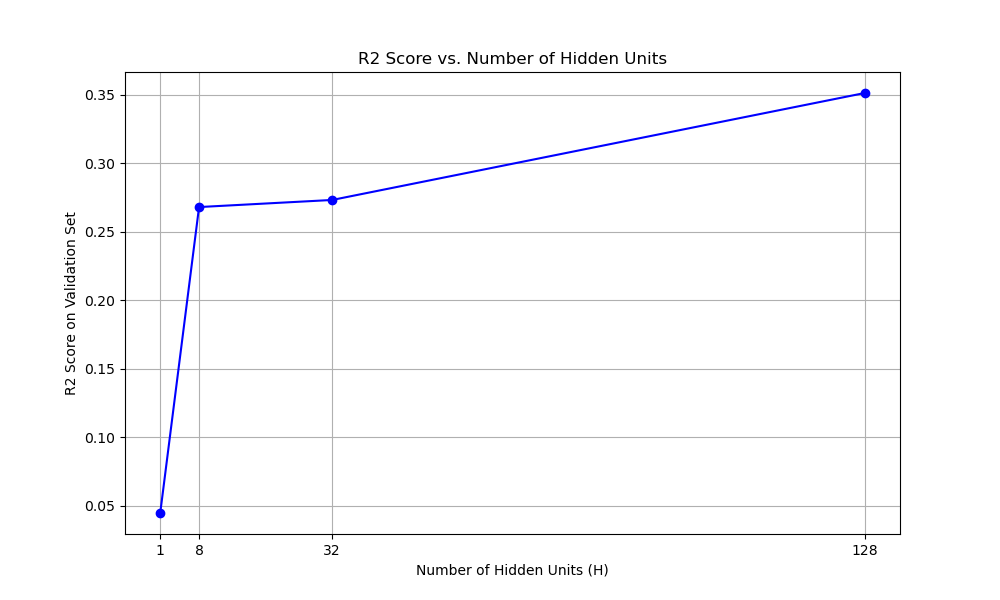

In [2571]:
if running_index == 8:
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_units, mean_r2_all, marker='o', linestyle='-', color='b')
    plt.title('R2 Score vs. Number of Hidden Units')
    plt.xlabel('Number of Hidden Units (H)')
    plt.ylabel('R2 Score on Validation Set')
    plt.grid(True)
    plt.xticks(hidden_units)
    plt.savefig('./pic/R2_Score_vs_Hidden_Units.png')
    plt.show()

    running_index = running_index + 1
    if exist_index == -1:
        running_index = -1

else:
    image_path = './pic/R2_Score_vs_Hidden_Units.png' 
    display(Image(filename=image_path))




## Part 4: Classification

In [2572]:
np.random.seed(random_seed)
random.seed(random_seed)
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(train_fe, train_labels['classification target'], test_size=0.2, random_state=random_seed)

### Logistic Regression:

#### Training Function for All Logistic Regression Model:

In [2573]:
def train_model_classification(X_train, y_train, X_test, y_test, n, lr_para = lr_para, trail = "", random_seed = random_seed):
    x = X_train
    y = y_train.values 

    regressor_c = SGDClassifier(**lr_para, random_state=random_seed)

    
    start_time = time.time()

    lrm = regressor_c.fit(x, y)

    training_time = time.time() - start_time

#    print("Training time:", training_time)

#    for name in lr_para:
#        print(name + ':', lr_para[name])

    training_accuracy = lrm.score(x, y)
#    print("Training accuracy:", lrm.score(x, y))

    y_pred = lrm.predict(X_test)
    y_v = y_test.values

    test_accuracy = np.mean(y_pred == y_v)
#    print("Testing accuracy:", np.mean(y_pred == y_v))

    f1 = f1_score(y_v, y_pred, average='weighted')
#    print("F1 score:", f1)

    if not os.path.exists('./result/classification'):
        os.makedirs('./result/classification')

#    with open(f'./result/classification/model{n+1}{trail}.txt', 'w') as f:
#        f.write("Training time: " + str(training_time) + '\n')
#        f.write("Learning rate: " + str(lr_para['learning_rate']) + '\n')
#        f.write("Eta0: " + str(lr_para['eta0']) + '\n')
#        f.write("Max iter: " + str(lr_para['max_iter']) + '\n')
#        f.write("Tol: " + str(lr_para['tol']) + '\n')
#        f.write("Training accuracy: " + str(lrm.score(x, y)) + '\n')
#        f.write("Testing accuracy: " + str(np.mean(y_pred == y_v)) + '\n')
#        f.write("F1 score: " + str(f1) + '\n')
    
    return lrm, training_time, f1, test_accuracy, training_accuracy

#### Non-repeat and Reported Model:

Learning Rateconstant
Eta0: 0.02
Max Iter: 1000
Tol: 0.001

Learning Rateconstant
Eta0: 0.01
Max Iter: 1000
Tol: 0.001
Average Training Time: 0.0025459925333658853 (±0.0006124838366040426)
Average F1 Score: 0.8472042863254946 (±0.0075961581875176685)
Average Testing Accuracy: 0.8516949152542374 (±0.007202004962701654)
Average Training Accuracy: 0.8147886494760392 (±0.007125216187640311)

Learning Rateconstant
Eta0: 0.02
Max Iter: 1000
Tol: 0.01
Average Training Time: 0.0021947224934895835 (±0.00028891612427465595)
Average F1 Score: 0.8122466213332985 (±0.01778057198898742)
Average Testing Accuracy: 0.8173258003766479 (±0.01711832294039347)
Average Training Accuracy: 0.7855881314023313 (±0.011936944718273286)

Learning Rateconstant
Eta0: 0.01
Max Iter: 1000
Tol: 0.01
Average Training Time: 0.001870870590209961 (±5.0613668213178815e-06)
Average F1 Score: 0.8282822123848673 (±0.012242552535037624)
Average Testing Accuracy: 0.8323917137476459 (±0.012113634962588112)
Average Training Accura

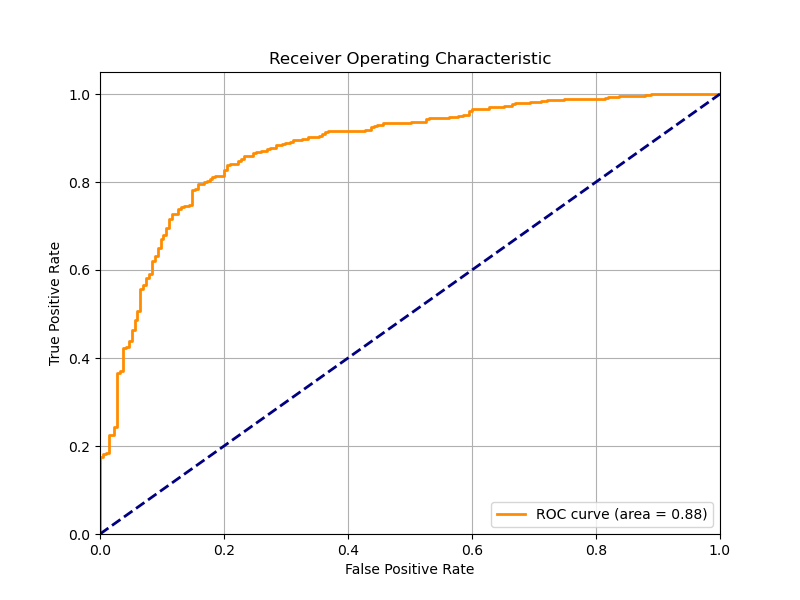

In [2574]:
eta0_list = [0.02, 0.01]
tol_list = [1e-3, 1e-2]
learning_rate_list = ['constant', 'optimal']

# Plot the ROC curve calculated on the validation set with the last model
if running_index == 9:

    for n in range(len(learning_rate_list)):
        for k in range(len(tol_list)):
            for j in range(len(eta0_list)):
                
                lr_para_test = {
                    'learning_rate':learning_rate_list[n], 
                    'eta0':eta0_list[j], 
                    'max_iter':1000, 
                    'tol':tol_list[k]
                    }

                training_times = []
                f1_scores = []
                test_accuracies = []
                training_accuracies = []

                for i in range(3):
                    model, training_time, f1, test_accuracy, training_accuracy = train_model_classification(
                        X_train_LR, y_train_LR, X_test_LR, y_test_LR, running_index, lr_para_test, f"_set{j}_trial_{i+1}", i+random_seed)

                    training_times.append(training_time)
                    f1_scores.append(f1)
                    test_accuracies.append(test_accuracy)
                    training_accuracies.append(training_accuracy)

                for name in lr_para_test:
                    print(name + ':', lr_para_test[name])

                avg_training_time = np.mean(training_times)
                std_training_time = np.std(training_times)

                avg_f1_score = np.mean(f1_scores)
                std_f1_score = np.std(f1_scores)

                avg_test_accuracy = np.mean(test_accuracies)
                std_test_accuracy = np.std(test_accuracies)

                avg_training_accuracy = np.mean(training_accuracies)
                std_training_accuracy = np.std(training_accuracies)

                print(f"Average Training Time: {avg_training_time} (±{std_training_time})")
                print(f"Average F1 Score: {avg_f1_score} (±{std_f1_score})")
                print(f"Average Testing Accuracy: {avg_test_accuracy} (±{std_test_accuracy})")
                print(f"Average Training Accuracy: {avg_training_accuracy} (±{std_training_accuracy})")
                print()

                if j == len(eta0_list) - 1 and k == len(tol_list) - 1 and n == len(learning_rate_list) - 1:
                    y_score = model.decision_function(X_test_LR)

                    fpr, tpr, _ = roc_curve(y_test_LR, y_score, pos_label='success')
                    roc_auc = auc(fpr, tpr)

                    plt.figure(figsize=(8, 6))
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic')
                    plt.legend(loc="lower right")
                    plt.grid(True)
                    plt.savefig(f'./pic/ROC_curve_set{4*n + 2*k +j}.png')
                    plt.show()     

                if not os.path.exists('./result/classification'):
                    os.makedirs('./result/classification')

                with open('output.txt', 'w', encoding='utf-8') as f:
                    f.write(f"Max Iter: {lr_para_test['max_iter']}\n")
                    f.write(f"Tol: {lr_para_test['tol']}\n")
                    f.write(f"Average Training Time: {avg_training_time} (±{std_training_time})\n")
                    f.write(f"Average F1 Score: {avg_f1_score} (±{std_f1_score})\n")
                    f.write(f"Average Testing Accuracy: {avg_test_accuracy} (±{std_test_accuracy})\n")
            
    running_index = running_index + 1

    if exist_index == -1:
        running_index = -1
    
else:
    for n in range(8):
        with open(f'./result/classification/model10_set{n}.txt', 'r', encoding='utf-8') as f:
            print(f.read())

    image_path = './pic/ROC_curve_set7.png'

    display(Image(filename=image_path))

#### Different Learning Rate

In [2575]:
eta0_list = [0.05, 0.04, 0.03, 0.02, 0.01]
# Plot the ROC curve calculated on the validation set with the last model
if running_index == 10:

    for j in range(len(eta0_list)):

        eta0 = eta0_list[j]
        lr_para_test = {
            'learning_rate':'constant', 
            'eta0':eta0, 
            'max_iter':1000, 
            'tol':1e-3
            }

        model, training_time, f1, test_accuracy, training_accuracy = train_model_classification(
                X_train_LR, y_train_LR, X_test_LR, y_test_LR, running_index, lr_para_test, f"_set{j}_trial_{i+1}", random_seed)

        print(f"Learning Rate: {lr_para_test['learning_rate']}")
        print(f"Training Time: {training_time}")
        print(f"F1 Score: {f1}")
        print(f"Testing Accuracy: {test_accuracy}")
        print(f"Training Accuracy: {training_accuracy}")
        print()

        if not os.path.exists('./result/classification'):
            os.makedirs('./result/classification')

        with open(f'./result/classification/model{running_index+1}_lr{eta0}.txt', 'w') as f:
            f.write(f"Learning Rate" + str(lr_para_test['learning_rate']) + '\n')
            f.write(f"Eta0: {lr_para_test['eta0']}\n")
            f.write(f"Max Iter: {lr_para_test['max_iter']}\n")
            f.write(f"Tol: {lr_para_test['tol']}\n")
            f.write(f"Training Time: {training_time}\n")
            f.write(f"F1 Score: {f1}\n")
            f.write(f"Testing Accuracy: {test_accuracy}\n")
            f.write(f"Training Accuracy: {training_accuracy}\n")

    running_index = running_index + 1

else:
    for j in range(len(eta0_list)):
        with open(f'./result/classification/model11_lr{eta0_list[j]}.txt', 'r') as f:
            print(f.read())

Learning Rateconstant
Eta0: 0.05
Max Iter: 1000
Tol: 0.001
Training Time: 0.003580331802368164
F1 Score: 0.7659580575475979
Testing Accuracy: 0.7740112994350282
Training Accuracy: 0.7237725185446838

Learning Rateconstant
Eta0: 0.04
Max Iter: 1000
Tol: 0.001
Training Time: 0.0037221908569335938
F1 Score: 0.7997900801428992
Testing Accuracy: 0.806497175141243
Training Accuracy: 0.7594489579653833

Learning Rateconstant
Eta0: 0.03
Max Iter: 1000
Tol: 0.001
Training Time: 0.0036585330963134766
F1 Score: 0.7821879756936488
Testing Accuracy: 0.788135593220339
Training Accuracy: 0.7545037089367714

Learning Rateconstant
Eta0: 0.02
Max Iter: 1000
Tol: 0.001
Training Time: 0.0047740936279296875
F1 Score: 0.8164100529410732
Testing Accuracy: 0.8177966101694916
Training Accuracy: 0.7788767220063582

Learning Rateconstant
Eta0: 0.01
Max Iter: 1000
Tol: 0.001
Training Time: 0.005235433578491211
F1 Score: 0.8478727374059388
Testing Accuracy: 0.8531073446327684
Training Accuracy: 0.8202048746026139


### Feedforward Neural Networks

Training times: [0.04103684425354004, 0.09674787521362305, 0.09462714195251465]
Accuracy: [0.3036723163841808, 0.3036723163841808, 0.6963276836158192]
F1: [0.1414724767553605, 0.1414724767553605, 0.5716728526604478]
mean time: 0.0775, std time: 0.0258
Mean Accuracy: 0.4346, Std Accuracy: 0.1851
Mean F1: 0.2849, Std F1: 0.2028

Training times: [0.314042329788208, 0.15592384338378906, 0.12364578247070312]
Accuracy: [0.8587570621468926, 0.8389830508474576, 0.8206214689265536]
F1: [0.8519781201964978, 0.8332451160026635, 0.8084641932828253]
mean time: 0.1979, std time: 0.0832
Mean Accuracy: 0.8395, Std Accuracy: 0.0156
Mean F1: 0.8312, Std F1: 0.0178

Training times: [0.3777644634246826, 0.5170519351959229, 0.5198516845703125]
Accuracy: [0.8629943502824858, 0.8516949152542372, 0.8686440677966102]
F1: [0.8571452834426058, 0.8437568890768312, 0.8643437140138147]
mean time: 0.4716, std time: 0.0663
Mean Accuracy: 0.8611, Std Accuracy: 0.0070
Mean F1: 0.8551, Std F1: 0.0085

Training times: [1

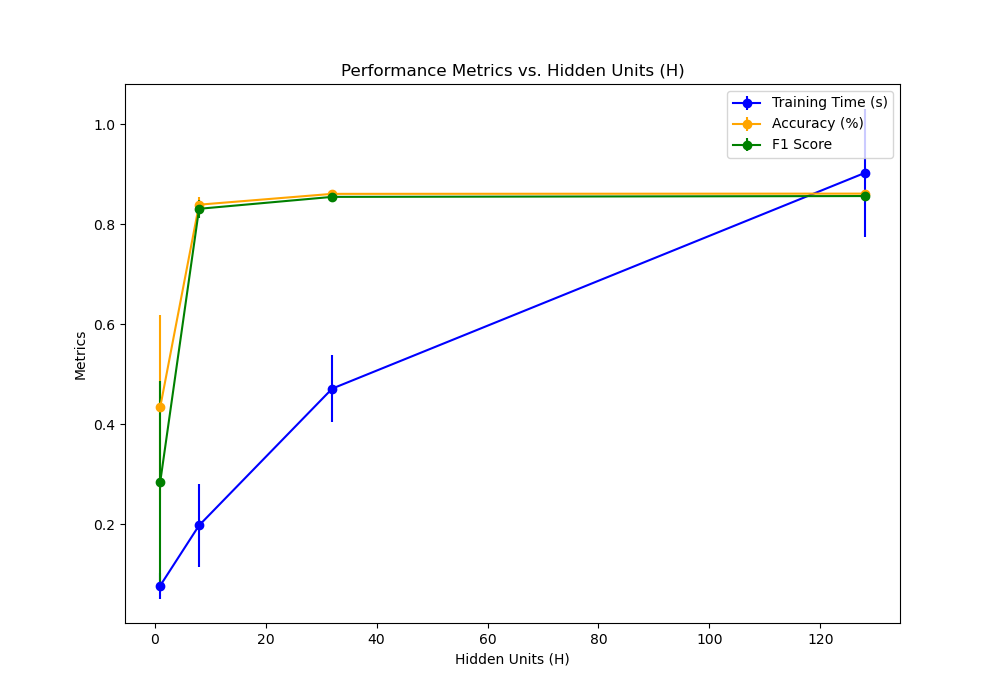

In [2576]:
hidden_units = [1, 8, 32, 128]

np.random.seed(random_seed)
random.seed(random_seed)

if running_index == 11:

    results = []

    for h in hidden_units:

        training_times_list_LR = []
        accuracy_list_LR = []
        f1_list_LR = []

        for _ in range(repeats_index): 
            
            performance = {'accuracy': [], 'f1': [], 'training_time': []}
            
            random_state = random.randint(5000, 6000)

            start_time = time.time()
            model = MLPClassifier(hidden_layer_sizes=(h, h, h), early_stopping=True, max_iter=800, random_state=random_state)
            model.fit(X_train_LR, y_train_LR)
            training_time = time.time() - start_time
            training_times_list_LR.append(training_time)

            y_pred_LR = model.predict(X_test_LR)

            accuracy = accuracy_score(y_test_LR, y_pred_LR)
            f1 = f1_score(y_test_LR, y_pred_LR, average='weighted')
            accuracy_list_LR.append(accuracy)
            f1_list_LR.append(f1)
            
        performance['accuracy'] = accuracy_list_LR
        performance['f1'] = f1_list_LR
        performance['training_time'] = training_times_list_LR

        std_time = np.std(performance['training_time'])
        mean_time = np.mean(performance['training_time'])
        std_accuracy = np.std(performance['accuracy'])
        mean_accuracy = np.mean(performance['accuracy'])
        std_f1 = np.std(performance['f1'])
        mean_f1 = np.mean(performance['f1'])

        results.append({
            'hidden_units': h,
            'mean_time': mean_time,
            'std_time': std_time,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'mean_f1': mean_f1,
            'std_f1': std_f1
        })

        print(f"Hidden units: {h}")
        print(f"Training times: {performance['training_time']}")
        print(f"Accuracy: {performance['accuracy']}")
        print(f"F1: {performance['f1']}")
        print(f"mean time: {mean_time:.4f}, std time: {std_time:.4f}")
        print(f"Mean Accuracy: {mean_accuracy:.4f}, Std Accuracy: {std_accuracy:.4f}")
        print(f"Mean F1: {mean_f1:.4f}, Std F1: {std_f1:.4f}\n")

        if not os.path.exists('./result/classification'):
            os.makedirs('./result/classification')

        with open(f'./result/classification/model12_H{h}.txt', 'w') as f:
            f.write(f"Training times: {performance['training_time']}\n")
            f.write(f"Accuracy: {performance['accuracy']}\n")
            f.write(f"F1: {performance['f1']}\n")
            f.write(f"mean time: {mean_time:.4f}, std time: {std_time:.4f}\n")
            f.write(f"Mean Accuracy: {mean_accuracy:.4f}, Std Accuracy: {std_accuracy:.4f}\n")
            f.write(f"Mean F1: {mean_f1:.4f}, Std F1: {std_f1:.4f}\n")

        with open(f'./result/classification/model12_H{h}.pkl', 'wb') as f:
            pickle.dump(model, f)

        if h == hidden_units[-1]:
            fig, ax = plt.subplots(figsize=(10, 7))  # 创建一个绘图对象和一个轴对象

            hs = [result['hidden_units'] for result in results]
            mean_times = [result['mean_time'] for result in results]
            std_times = [result['std_time'] for result in results]
            ax.errorbar(hs, mean_times, yerr=std_times, label='Training Time (s)', fmt='-o', color='blue')

            mean_accuracies = [result['mean_accuracy'] for result in results]
            std_accuracies = [result['std_accuracy'] for result in results]
            ax.errorbar(hs, mean_accuracies, yerr=std_accuracies, label='Accuracy (%)', fmt='-o', color='orange')

            mean_f1s = [result['mean_f1'] for result in results]
            std_f1s = [result['std_f1'] for result in results]
            ax.errorbar(hs, mean_f1s, yerr=std_f1s, label='F1 Score', fmt='-o', color='green')

            ax.set_title('Performance Metrics vs. Hidden Units (H)')
            ax.set_xlabel('Hidden Units (H)')
            ax.set_ylabel('Metrics')

            ax.legend()

            fig.savefig('./pic/Combined_Performance_vs_H.png')

        running_index = running_index + 1

        if exist_index == -1:
            running_index = -1

else:
    for h in hidden_units:
        with open(f'./result/classification/model12_H{h}.txt', 'r') as f:
            print(f.read())

    image_path = './pic/Combined_Performance_vs_H.png'

    display(Image(filename=image_path))


## Part 5: Performance Enhancement

### Data Split:

In [2577]:
np.random.seed(4211)
X_train_PE, X_test_PE, y_train_PE, y_test_PE = train_test_split(train, train_labels, test_size=0.2, random_state=4211)

cols = X_train_PE.columns
numerical_cols = X_train_PE.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train_PE.select_dtypes(include=['object', 'bool']).columns

#### Function

In [2578]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error

def pipeline_model(imputer, scaler, encoder):
    
    numerical_pipeline = Pipeline([
        ('imputer', imputer),
        ('scaler', scaler)
    ])

    categorical_pipeline = Pipeline([
        ('encoder', encoder),
        ('imputer', imputer)

    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

    pipeline_c = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100, 100, 100), random_state=4211))
    ])

    pipeline_r = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MLPRegressor(hidden_layer_sizes=(100, 100, 100), random_state=4211))
    ])

    return pipeline_c, pipeline_r


def evaluate_combinations(pipeline_c,pipeline_r,X_train, y_train_class, y_train_reg, X_test, y_test_class, y_test_reg,running_index):

    # Classification
    pipeline_c.fit(X_train, y_train_class)
    y_pred_c = pipeline_c.predict(X_test)
    accuracy_c = accuracy_score(y_test_class, y_pred_c)
    if running_index != 14:
        f1 = f1_score(y_test_class, y_pred_c, pos_label='success')
    else:
        f1 = f1_score(y_test_class, y_pred_c, pos_label=  1 )
    
    print(f'Combination {running_index-12} - Classification - Accuracy: {accuracy_c}, F1 Score: {f1}')
    
    # Regression
    pipeline_r.fit(X_train, y_train_reg)
    y_pred_r = pipeline_r.predict(X_test)
    r2 = r2_score(y_test_reg, y_pred_r)
    mse = mean_squared_error(y_test_reg, y_pred_r)
    
    print(f'Combination {running_index-12} - Regression - R2 Score: {r2}, MSE: {mse}')
    
    # Ensure the result directory exists
    result_dir = './result/combination'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    with open(f'{result_dir}/combination_{running_index-12}.txt', 'w') as f:
        f.write(f'Combination {running_index-12} - Classification - Accuracy: {accuracy_c}, F1 Score: {f1}\n')
        f.write(f'Combination {running_index-12} - Regression - R2 Score: {r2}, MSE: {mse}\n')


### Combination A

In [2579]:
if running_index == 12:
    regressor_c_a, regressor_r_a = pipeline_model(SimpleImputer(strategy='mean'),StandardScaler(),OneHotEncoder(handle_unknown='ignore'))
    evaluate_combinations(regressor_c_a, regressor_r_a, X_train_PE, y_train_PE['classification target'], y_train_PE['regression target'], X_test_PE, y_test_PE['classification target'], y_test_PE['regression target'], running_index)

    running_index = running_index + 1

    if exist_index == -1:
        running_index = -1

else:
    with open(f'./result/combination/combination_0.txt', 'r') as f:
        print(f.read())

Combination 0 - Classification - Accuracy: 0.8516949152542372, F1 Score: 0.8961424332344213
Combination 0 - Regression - R2 Score: 0.22421865294132537, MSE: 0.0037737215549623446



### Combination B

In [2580]:
if running_index == 13:
    regressor_c_b, regressor_r_b = pipeline_model(SimpleImputer(strategy='constant', fill_value=0),MinMaxScaler(),OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
    evaluate_combinations(regressor_c_b, regressor_r_b, X_train_PE, y_train_PE['classification target'], y_train_PE['regression target'], X_test_PE, y_test_PE['classification target'], y_test_PE['regression target'], running_index)

    running_index = running_index + 1
    
    if exist_index == -1:
        running_index = -1

else:
    with open(f'./result/combination/combination_1.txt', 'r') as f:
        print(f.read())


Combination 1 - Classification - Accuracy: 0.8615819209039548, F1 Score: 0.9031620553359684
Combination 1 - Regression - R2 Score: 0.3083562239584424, MSE: 0.0033644415864076804



### Combination C

In [2581]:
if running_index == 14:
    ordinal_cols= ['C2','C5']
    nominal_cols = categorical_cols.difference(ordinal_cols)

    label_encoder = LabelEncoder()
    y_train_PE_c = label_encoder.fit_transform(y_train_PE['classification target'])
    y_test_PE_c = label_encoder.transform(y_test_PE['classification target'])


    numerical_pipeline_c = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler()) #,
        #('cluser', UMAP(n_components=10, n_neighbors=20))
    ])

    numerical_pipeline_r = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('PAC', PCA(n_components=10))
    ])

    ordinal_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

    nominal_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist'))
    ])

    preprocessor_c = ColumnTransformer(transformers=[
        ('num', numerical_pipeline_c, numerical_cols),
        ('ord', ordinal_pipeline, ordinal_cols),
        ('nom', nominal_pipeline, list(nominal_cols)),
    ])

    preprocessor_r = ColumnTransformer(transformers=[
        ('num', numerical_pipeline_r, numerical_cols),
        ('ord', ordinal_pipeline, ordinal_cols),
        ('nom', nominal_pipeline, list(nominal_cols)),
    ])

    pipeline_c = Pipeline([
        ('preprocessor', preprocessor_c),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100, 100, 100), random_state=4211, max_iter=800))
    ])

    pipeline_r = Pipeline([
        ('preprocessor', preprocessor_r),
        ('regressor', MLPRegressor(hidden_layer_sizes=(100, 100, 100), random_state=4211, max_iter=800))
    ])

    evaluate_combinations(pipeline_c, pipeline_r, X_train_PE, y_train_PE_c, y_train_PE['regression target'], X_test_PE, y_test_PE_c, y_test_PE['regression target'], running_index)
    
    running_index = running_index + 1

    if exist_index == -1:
        running_index = -1

else:
    with open(f'./result/combination/combination_2.txt', 'r') as f:
        print(f.read())


Combination 2 - Classification - Accuracy: 0.8545197740112994, F1 Score: 0.8950050968399593
Combination 2 - Regression - R2 Score: 0.3545329404264892, MSE: 0.003139818925739773



### Hyperparemeter Tuning

In [2582]:
if running_index == 15:
    np.random.seed(4211)
    X_train_HT, X_test_HT, y_train_HT, y_test_HT = train_test_split(train, train_labels['classification target'], test_size=0.2, random_state=4211)

    cols = X_train_PE.columns
    numerical_cols = X_train_HT.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X_train_HT.select_dtypes(include=['object', 'bool']).columns

    ordinal_cols= ['C2','C5']
    nominal_cols = categorical_cols.difference(ordinal_cols)

    label_encoder = LabelEncoder()
    y_train_HT = label_encoder.fit_transform(y_train_HT)
    y_test_HT = label_encoder.transform(y_test_HT)


    numerical_pipeline_ht = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler()) #,
        #('cluser', UMAP(n_components=10, n_neighbors=20))
    ])

    ordinal_pipeline_ht = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

    nominal_pipeline_ht = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist'))
    ])

    preprocessor_ht = ColumnTransformer(transformers=[
        ('num', numerical_pipeline_ht, numerical_cols),
        ('ord', ordinal_pipeline_ht, ordinal_cols),
        ('nom', nominal_pipeline_ht, list(nominal_cols)),
    ])


    pipeline_ht = Pipeline([
        ('preprocessor', preprocessor_ht),
        ('classifier', MLPClassifier(random_state=4211, max_iter=800,  early_stopping=True))
    ])

    param_grid = {
        'classifier__hidden_layer_sizes': [(50, 50, 50), (100, 100, 100), (200, 200, 200)],
        'classifier__activation': ['tanh', 'relu'], 
        'classifier__solver': ['sgd', 'adam'],
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__learning_rate': ['constant', 'adaptive'],
    }


    grid_search = GridSearchCV(pipeline_ht, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X_train_HT, y_train_HT)

    print("Number of combinations:", len(grid_search.cv_results_['params']))

    print("Best parameters:", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    print("Best cross-validation accuracy:", grid_search.best_score_)
    print("Test set score:", best_model.score(X_test_HT, y_test_HT))
    print("F1 score:", f1_score(y_test_HT, best_model.predict(X_test_HT), average='weighted'))
    print()

    results = grid_search.cv_results_
    for i in range(5):
        print(f"Rank: {i+1}")
        print(f"Mean validation accuracy: {results['mean_test_score'][i]}")
        print(f"Standard deviation: {results['std_test_score'][i]}")
        print(f"Parameters: {results['params'][i]}")
        print()

    if not os.path.exists('./result/combination'):
        os.makedirs('./result/combination')

    with open(f'./result/combination/combination_3.txt', 'w') as f:
        f.write("Number of combinations: " + str(len(grid_search.cv_results_['params'])) + "\n")
        f.write("Best parameters: " + str(grid_search.best_params_) + "\n")
        f.write("Best cross-validation accuracy: " + str(grid_search.best_score_) + "\n")
        f.write("Test set score: " + str(best_model.score(X_test_HT, y_test_HT)) + "\n")
        f.write("F1 score: " + str(f1_score(y_test_HT, best_model.predict(X_test_HT), average='weighted')) + "\n" + "\n")
        for i in range(5):
            f.write(f"Rank: {i+1}\n")
            f.write(f"Mean validation accuracy: {results['mean_test_score'][i]}\n")
            f.write(f"Standard deviation: {results['std_test_score'][i]}\n")
            f.write(f"Parameters: {results['params'][i]}\n" + "\n")

    running_index = running_index + 1

    if exist_index == -1:
        running_index = -1

else:
    with open(f'./result/combination/combination_3.txt', 'r') as f:
        print(f.read())




Number of combinations: 72
Best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100, 100, 100), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
Best cross-validation accuracy: 0.8703579062825234
Test set score: 0.8813559322033898
F1 score: 0.8768938460780448

Rank: 1
Mean validation accuracy: 0.8424520600021189
Standard deviation: 0.021633665759334272
Parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'sgd'}

Rank: 2
Mean validation accuracy: 0.867535413589595
Standard deviation: 0.009180967789985598
Parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}

Rank: 3
Mean validation accuracy: 0.8459831360891432
Standard deviation: 0.0